# Задача классификации жестов
# Motorica
#### 2 этап

## Библиотеки

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Функции

In [24]:
def sensor_treshold_filtr(array, tres = 250):
    """Функция производит пороговую фильтрацию массива. 
    Исключаются строки, где максимальное значение не превышает пороговое значение.
    Аргументы: array - входной массив,
               tres - пороговое значение.
    Возвращает отфильтрованный массив."""
    low_sensors_set = set()               # 
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i,j].max() <= tres:
                low_sensors_set.add(j)
    low_sens_list = list(low_sensors_set)
    array_out = np.delete(array, low_sens_list, 1)
    return array_out

## Загрузка и описание данных

Данные представляют из себя временные ряды, где в каждый момент времени фиксируются показания от датчиков.  
Целевая переменная представляет из себя маску команды выполняемого пользователем жеста в каждый момент времени.  

* X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);
* y_train.csv и y_test.csv имеют следующие размерности (наблюдения * время) - это обусловленно форматом ответов для Kaggle;
* y_train.csv содержит следующие классы:

0 - команда "жест open";  
1 - команда "сгиб мизинца";  
2 - команда "сгиб безымянного пальца";  
3 - команда "сгиб среднего пальца";  
4 - команда "жест пистолет";  
5 - команда "сгиб указательного пальца";  
6 - команда "сгиб большога пальца";  
7 - команда "жест ОК";  
8 - команда "жест grab";  

In [25]:
# загружаем тренировочные данные
X_train = np.load ( 'X_train.npy')

# смотрим форму тренировочных данных
X_train.shape

(323, 40, 100)

In [26]:
# загружаем тестовые данные
X_test = np.load ( 'X_test.npy')
y_test = pd.read_csv('sample_submission.csv')
# смотрим форму тестовых данных
X_test.shape

(323, 40, 100)

In [27]:
# загружаем маску выполнения жеста для тренировочной выборки
y_train = pd.read_csv('y_train.csv')

In [28]:
y_train.shape

(32300, 2)

## Анализ целевой переменной

In [29]:
# посмотрим пример маски выполнения жеста для тренировочной выборки
y_train.sample(3)

,sample-timestep,class
32070,320-70,7
30846,308-46,0
22983,229-83,0


In [30]:
# сделаем копию y_train
y = y_train.copy()

In [31]:
# Разделим для каждого наблюдения признак 'sample-timestep' на признаки 'sample' и 'timestep'
y['sample'] = y_train['sample-timestep'].apply(lambda x: x.split('-')[0])
y['timestep'] = y_train['sample-timestep'].apply(lambda x: x.split('-')[1])

In [32]:
y.sample(3)

,sample-timestep,class,sample,timestep
22320,223-20,3,223,20
23657,236-57,6,236,57
18791,187-91,0,187,91


In [33]:
# Преобразуем признаки 'sample' и 'timestep' в числовой формат
y[['sample', 'timestep']] = y[['sample', 'timestep']].astype(int)

In [34]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32300 entries, 0 to 32299
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sample-timestep  32300 non-null  object
 1   class            32300 non-null  int64 
 2   sample           32300 non-null  int32 
 3   timestep         32300 non-null  int32 
dtypes: int32(2), int64(1), object(1)
memory usage: 757.2+ KB


In [35]:
y

,sample-timestep,class,sample,timestep
0,0-0,0,0,0
1,0-1,0,0,1
2,0-2,0,0,2
3,0-3,0,0,3
4,0-4,0,0,4
...,...,...,...,...
32295,322-95,4,322,95
32296,322-96,4,322,96
32297,322-97,4,322,97
32298,322-98,4,322,98


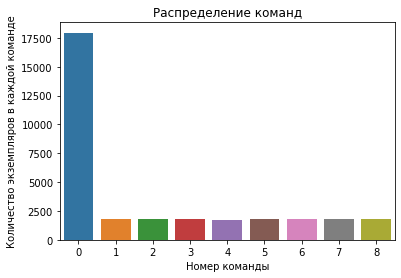

In [36]:
# построим график распределения команд 
class_vc = y['class'].value_counts()
plot = sns.barplot(data = y, x = class_vc.index, y = class_vc)
plot.set_title('Распределение команд')
plot.set_xlabel('Номер команды')
plot.set_ylabel('Количество экземпляров в каждой команде');

In [37]:
# Сгруппируем классы по наблюдениям и сформируем распределение классов для каждого наблюдения
class_distribution = y.groupby(by = 'sample')['class'].value_counts() 
class_distribution.head()

sample  class
0       0        100
1       0        100
2       0         50
        6         50
3       0         50
Name: class, dtype: int64

Гипотеза: в каждом наблюдении только два класса или один, смена класса происходит посередине временного ряда.

In [38]:
# Проверим гипотезу
n_samples_no_change = sum(m == 100 for m in class_distribution)
print('Количество наблюдений без смены класса', n_samples_no_change)
n_sampl_change_class_in_half = sum(m == 50 for m in class_distribution)//2
print('Количество наблюдений, где класс меняется посередине временного ряда',n_sampl_change_class_in_half)
n_sampl_change_class_not_half = sum((m != 50)&(m != 100) for m in class_distribution)
print('Количество наблюдений, где класс меняется не посередине временного ряда',n_sampl_change_class_not_half)

print('Общее количество наблюдений',y['sample'].nunique())


Количество наблюдений без смены класса 36
Количество наблюдений, где класс меняется посередине временного ряда 287
Количество наблюдений, где класс меняется не посередине временного ряда 0
Общее количество наблюдений 323


Гипотеза подтвердилась.  
Вывод, у трейн можно свернуть до 2х значений для каждого наблюдения, начальный класс и конечный

## Анализ массива входных данных X_train

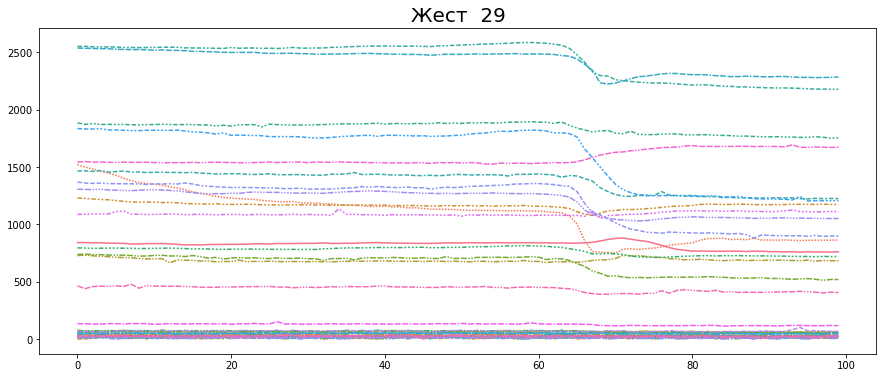

In [39]:
# посмотрим графически работу сенсоров при команде "сгиб мизинца"
g = 29
chan_df =  pd.DataFrame(X_train[g]).T
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.subplot(1, 1, 1)
lineplot = sns.lineplot(data = chan_df, legend = False, linestyle = 'solid')
a = 'Жест  '+ str(g)
lineplot.set_title(a, fontsize=20);

При изучении графиков выяснилось, что некоторое количество датчиков постоянно выдает сигналы малой амплитуды. Информативность таких сигналов несущественна, их можно отсечь с помощью пороговой фильтрации.

## Предварительная обработка массива входных данных X_train

In [40]:
# применим функцию, которая производит пороговую фильтрацию массива.
X_tres_train = sensor_treshold_filtr(X_train)
X_tres_train.shape

(323, 16, 100)

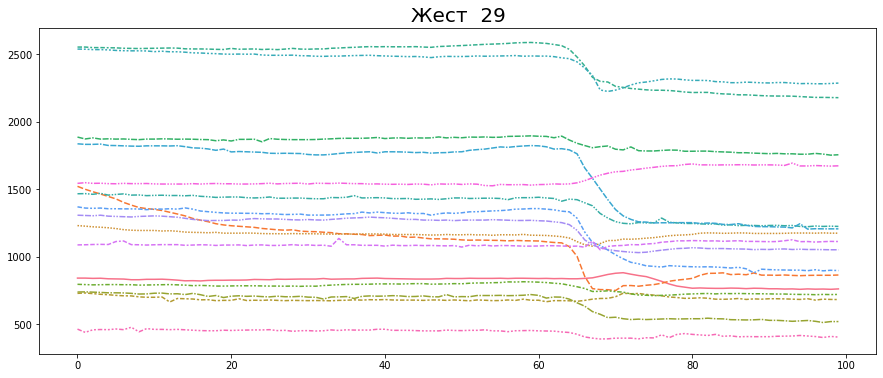

In [41]:
g = 29
chan_df =  pd.DataFrame(X_tres_train[g]).T
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.subplot(1, 1, 1)
lineplot = sns.lineplot(data = chan_df, legend = False, linestyle = 'solid')
a = 'Жест  '+ str(g)
lineplot.set_title(a, fontsize=20);

## Формирование списка координат смены класса для наблюдений

Для определения координат смены класса используем функцию diff.  
Экстремумы функции diff, имеющие абсолютные значения, меньшие значения параметра ***diff_tres*** будем считать ложными.  
Для устранения ложных ранних определений экстремумов diff не будем рассматривать экстремумы с координатами, меньшими параметра ***after***.  
Для компенсации задержки выполнения команд введем параметр временного сдвига  ***shift***.  

Все эти параметры определелялись экспериментально в процессе отладки модели. В коде представлены константы, которые мы считаем оптимальными. 

Для занесения в список координат смены класса рассматривались варианты:  
 -  координата первого экстремума diff изо всех сенсоров;
 -  координата последнего экстремума diff изо всех сенсоров;
 -  средняя координата экстремумов diff по всем сенсорам:
 -  координата самого большого экстремума diff изо всех сенсоров

Все варианты были опробованы экспериментально. Наилучший результат показал вариант координаты самого большого экстремума diff изо всех сенсоров.

In [42]:
from statistics import mean
diff_tres = 250               #  порог отсечения максимумов diff
step = 5                      #  шаг diff
after = 61                    # максимумы раньше after считать ложными
shift = -3                    # сдвиг координаты смены для компенсации задержки выполнения команды
coord_list = []               # список координат смены класса для наблюдений

for i in range(X_tres_train.shape[0]):           # Для каждого наблюдения формируем:
    chan_df =  pd.DataFrame(X_tres_train[i]).T   # df для текущего наблюдения
    diffmax_dict = {}                                  # Словарь для значений максимумов diff от сенсоров канала
    diffmin_dict = {}                                  # Словарь для значений минимумов diff от сенсоров канала

    for j in range(16):                                # Для каждого сенсора в текущем наблюдении:
        diff_current = chan_df[j].diff(step)                               # вычисляем diff
        # максимум diff заносим в словарь. Индекс словаря - значение максимума diff, 
        # значение словаря - индекс максимума diff. Если сделать наоборот (как кажется логичным), в словарь не сохраняются совпадающие индексы.
        if diff_current.idxmax() > after:                                 # если максимум diff позже after, 
            diffmax_dict[diff_current.max()] = diff_current.idxmax()      # добавляем его в словарь
    
        if diff_current.idxmin() > after:                                 # если минимум diff позже after,
            diffmin_dict[diff_current.min()] = diff_current.idxmin()      # добавляем его в словарь
            
    diffmax_tres_dict = {key:val for key, val in diffmax_dict.items() if key > diff_tres}            # в этот словарь заносятся максимумы diff, превышающие порог
 
    diffmin_tres_dict = {abs(key):val for key, val in diffmin_dict.items() if abs(key) > diff_tres}  # в этот словарь заносятся минимумы diff, превышающие порог
    diff_tres_dict = diffmax_tres_dict | diffmin_tres_dict                                           # Объединяем максимумы и минимумы в один словарь
    if len(list(diff_tres_dict.values())) == 0:                                                      # Если словарь максимумов и минимумов пустой, 
        latest_ind = earliest_ind = diff_max_ind = mean_ind =50-shift                                # то присваиваем координате смены класса 50
    else:                                                    # Из значений ниже для занесения в список координат смены класса для наблюдений будет выбрано одно
        latest_ind = max(list(diff_tres_dict.values()))      # Координата последнего максимумма diff изо всех сенсоров
        earliest_ind = min(list(diff_tres_dict.values()))    # Координата первого максимумма diff изо всех сенсоров
        diff_max = max(list(diff_tres_dict.keys()))                 # Самый большой максимум diff изо всех сенсоров
        diff_max_ind = diff_tres_dict[diff_max]              # Координата самого большого максимумма diff изо всех сенсоров
        mean_ind = int(mean(list(diff_tres_dict.values())))  # Средняя координата максимума diff по всем сенсорам
        
    # Для занесения в список координат смены класса для наблюдений выбрана координата самого большого максимумма diff изо всех сенсоров
    
    coord_list.append(diff_max_ind+shift)                         
print(len(coord_list))
print(coord_list)


323
[50, 50, 50, 70, 72, 64, 70, 67, 72, 64, 72, 63, 71, 66, 71, 67, 89, 66, 50, 50, 50, 66, 69, 67, 71, 59, 69, 65, 72, 67, 86, 65, 69, 66, 72, 67, 71, 50, 50, 63, 68, 50, 68, 65, 68, 66, 70, 50, 73, 62, 72, 50, 76, 71, 76, 50, 50, 68, 68, 67, 65, 70, 70, 63, 75, 64, 68, 65, 68, 63, 68, 65, 50, 50, 50, 66, 66, 64, 67, 67, 69, 68, 72, 64, 67, 64, 70, 66, 72, 70, 74, 50, 50, 69, 68, 68, 71, 67, 69, 67, 69, 64, 69, 61, 67, 66, 66, 67, 81, 50, 50, 66, 70, 67, 67, 66, 73, 60, 70, 63, 69, 63, 80, 65, 70, 65, 73, 50, 74, 64, 69, 65, 69, 63, 66, 66, 50, 50, 72, 63, 66, 50, 66, 67, 71, 50, 73, 66, 68, 66, 68, 62, 71, 68, 69, 66, 70, 65, 71, 66, 68, 65, 74, 50, 50, 66, 68, 65, 66, 67, 69, 65, 73, 67, 67, 64, 76, 68, 72, 62, 50, 50, 50, 64, 72, 66, 67, 65, 72, 67, 72, 50, 70, 64, 73, 65, 79, 64, 72, 50, 75, 70, 74, 59, 67, 68, 71, 66, 74, 68, 73, 66, 77, 69, 71, 64, 77, 50, 50, 68, 70, 68, 70, 69, 71, 66, 66, 66, 71, 65, 68, 63, 69, 63, 80, 50, 50, 66, 71, 66, 66, 66, 70, 65, 73, 62, 68, 62, 68,

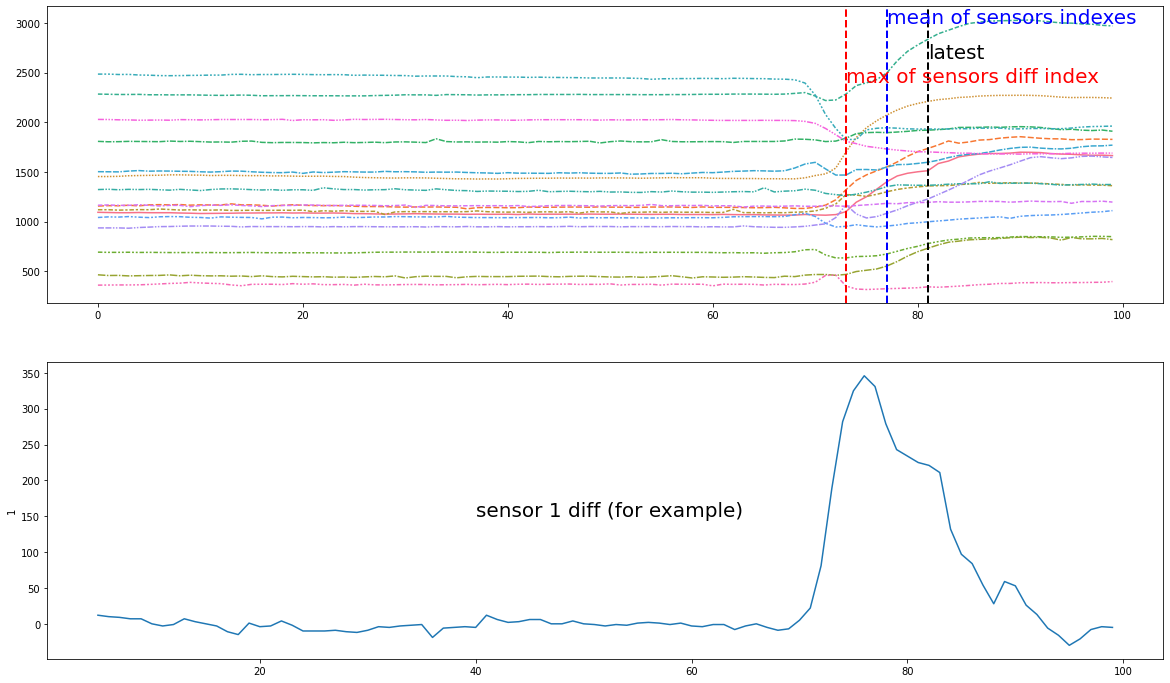

In [43]:
j = 1      # Сенсор для визуализации на нижнем графике
diff_current_ = chan_df[j].diff(step)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))
plt.subplot(2, 1, 2)
lineplot = sns.lineplot(data = diff_current_, legend = False, linestyle = 'solid')
lineplot.annotate('sensor 1 diff (for example)', xy =(40,150), fontsize=20, color='k')
plt.subplot(2, 1, 1)
lineplot = sns.lineplot(data = chan_df, legend = False, linestyle = 'solid')
    
lineplot.axvline(mean_ind, color='b', ls='--', lw=2)
lineplot.axvline(diff_max_ind, color='r', ls='--', lw=2)
lineplot.axvline(latest_ind, color='k', ls='--', lw=2)
lineplot.annotate('latest', xy =(latest_ind,2650), fontsize=20, color='k')
lineplot.annotate('max of sensors diff index', xy =(diff_max_ind,2400), fontsize=20, color='r')
lineplot.annotate('mean of sensors indexes', xy =(mean_ind,3000), fontsize=20, color='b');

## Переразметка y_train c использованием списка координат смены класса для наблюдений

In [44]:
# Сформируем список сдвига координат смены класса из списка координат смены класса для наблюдений
shift_coord_list = []
for i in range(len(coord_list)):
    shift_coord_list.append(coord_list[i]-50)
print(shift_coord_list)

[0, 0, 0, 20, 22, 14, 20, 17, 22, 14, 22, 13, 21, 16, 21, 17, 39, 16, 0, 0, 0, 16, 19, 17, 21, 9, 19, 15, 22, 17, 36, 15, 19, 16, 22, 17, 21, 0, 0, 13, 18, 0, 18, 15, 18, 16, 20, 0, 23, 12, 22, 0, 26, 21, 26, 0, 0, 18, 18, 17, 15, 20, 20, 13, 25, 14, 18, 15, 18, 13, 18, 15, 0, 0, 0, 16, 16, 14, 17, 17, 19, 18, 22, 14, 17, 14, 20, 16, 22, 20, 24, 0, 0, 19, 18, 18, 21, 17, 19, 17, 19, 14, 19, 11, 17, 16, 16, 17, 31, 0, 0, 16, 20, 17, 17, 16, 23, 10, 20, 13, 19, 13, 30, 15, 20, 15, 23, 0, 24, 14, 19, 15, 19, 13, 16, 16, 0, 0, 22, 13, 16, 0, 16, 17, 21, 0, 23, 16, 18, 16, 18, 12, 21, 18, 19, 16, 20, 15, 21, 16, 18, 15, 24, 0, 0, 16, 18, 15, 16, 17, 19, 15, 23, 17, 17, 14, 26, 18, 22, 12, 0, 0, 0, 14, 22, 16, 17, 15, 22, 17, 22, 0, 20, 14, 23, 15, 29, 14, 22, 0, 25, 20, 24, 9, 17, 18, 21, 16, 24, 18, 23, 16, 27, 19, 21, 14, 27, 0, 0, 18, 20, 18, 20, 19, 21, 16, 16, 16, 21, 15, 18, 13, 19, 13, 30, 0, 0, 16, 21, 16, 16, 16, 20, 15, 23, 12, 18, 12, 18, 15, 21, 15, 23, 0, 0, 17, 23, 14, 19, 15,

In [45]:
# Преобразуем y_train в двумерный массив 
y_train_2d = y_train.copy()
y_train_2d[['sample_id', 'timestep']] = y_train_2d['sample-timestep'].str.split('-', 1, expand=True).astype(int)
y_train_2d = y_train_2d.pivot(index='sample_id', columns='timestep', values='class')
y_train_2d_index = y_train_2d.index
y_train_2d = y_train_2d.sort_index() # на всякий случай
y_train_2d = y_train_2d.values

print(y_train_2d.shape)

(323, 100)


In [46]:
# Сформируем новый массив y_train со сдвигом для каждого наблюдения

y_tr_shift = np.zeros((y_train_2d.shape[0], y_train_2d.shape[1])).astype(int)
for i in range(y_train_2d.shape[0]):
    curr_row = pd.Series(y_train_2d[i])
    curr_shift = shift_coord_list[i]
    curr_row_shift = curr_row.shift(curr_shift)      # сдвиг строки текущего наблюдения
    curr_row_shift[0:curr_shift] = curr_row[0]       # заполняем начало строки исходным значением
    y_tr_shift[i] = curr_row_shift

In [47]:
# Преобразуем y_train в исходный вид
y_tr_shift = y_tr_shift.reshape(y_train.shape[0])
y_tr_shift = pd.Series(y_tr_shift)

In [48]:
# Распределение классов с новой разметкой
y_tr_shift.value_counts()

0    18511
6     1962
3     1768
2     1711
5     1705
1     1689
7     1672
8     1668
4     1614
dtype: int64

In [49]:
# Исходное распределение классов
y_train['class'].value_counts()

0    17950
6     1800
5     1800
3     1800
2     1800
1     1800
8     1800
7     1800
4     1750
Name: class, dtype: int64

В новой разметке доля класса 0 выросла, так как смена классов происходит не в середине временного диапазона, а в момент фронта графиков, определяемый с помощью diff

In [50]:
# формируем файл с предобработанной целевой переменной, если нужно для использования в других ноутбуках
#file_name = 'y_train_'+str(diff_tres)+'_'+str(step)+'_'+ str(after)+'_'+ str(shift)+'.csv'
#y_tr_shift.to_csv(file_name, index=False)

# Решение задачи с помощью нейронной сети.

В качестве `y_train` возьмем свою разметку, в которой переход класса определяется по максимальному изменению показаний одного из 16 датчиков. Для увеличения качества НН, установим точку перехода классов на 3 элемента раньше, чем наступает максимум из изменений датчиков.

In [51]:
#загрузка разметки целевой переменной из файла, если используем другую заранее подготовленную разметку
#y_train = pd.read_csv('./y_train_250_5_61_-3.csv')
y_train = y_tr_shift               #берем новую разметку целевой переменной из предыдущего блока


print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300,)
(54, 40, 100)


Преобразуем размерность `y_train` к размерности `X_train`

In [52]:
y_train = y_train.values.reshape((X_train.shape[0], X_train.shape[2]))
y_train.shape

(323, 100)

## Объяснение данных.

### Train

In [53]:
X_train.shape, y_train.shape

((323, 40, 100), (323, 100))

`y_train` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

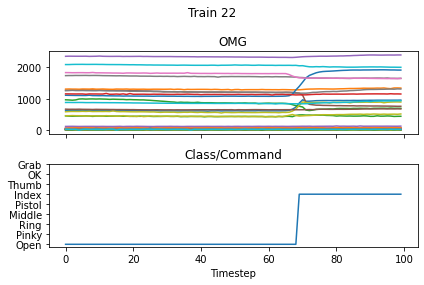

In [54]:
i = 22
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

### Test

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - распознать, **какая команда была выполнена пользователем и в какое время**.

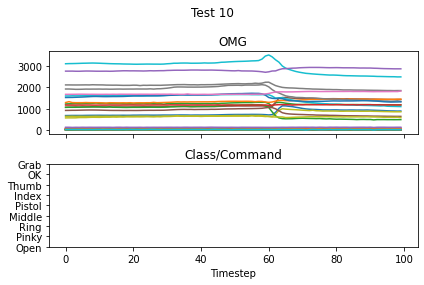

In [55]:
i = 10
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test {i}')

plt.tight_layout()

# NN Baseline.

In [56]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## Предобработка данных.

In [57]:
# Фильтруем значения датчиков
X_train = sensor_treshold_filtr(X_train)
X_test = sensor_treshold_filtr(X_test)

# Подготовка данных для подачи их в НН

# Меняем местами ось времени и ось показаний датчиков
X_train_nn = X_train.swapaxes(1, 2)
X_test_nn = X_test.swapaxes(1, 2)

# Переводим категориальные данные в OHE
y_train_nn = tf.keras.utils.to_categorical(y_train)

# Смотрим получившиеся размерности
print(X_train_nn.shape, y_train_nn.shape)
print(X_test_nn.shape)

(323, 100, 16) (323, 100, 9)
(54, 100, 16)


## Кросс-валидация.

Для оценки параметров модели используем алгоритм кросс-валидации:
1. Разделим данные на k частей.
2. В цикле обучаем модель на k-1 частях, производим оценку качества
модели на оставшейся части.
3. Усредняем значения метрики на валидационных фолдах.

### Разделим данные для кросс-валидации.

In [58]:
def cross_val_train_test_split(kfold:int, X, y):
    """Разделим Х, у на kfold частей.

    Для проведения кросс-валидации разделим набор данных
    на kfold частей. Каждая часть содержит свой набор
    тренировочных и тестовых данных для проведения алгоритма
    кросс-валидации.
    
    Аргументы:
        kfold (int): количество частей, на которые делится выборка
        X (np.array): массив признаков.
        y (np.array): массив целевой переменной.
    
    Возвращает:
        splitted_Xy (list): список готовых выборок для проведения
            кросс-валидации в виде (X_train, X_test, y_train, y_test).
     
    """
    splitted_Xy = []
    interval = X.shape[0] // kfold
    for fold in range(kfold):
        mask = np.ones(X.shape[0], dtype=bool)
        mask[fold*interval:(fold+1)*interval] = 0
        X_train = X[mask]
        X_test = X[~mask]
        y_train = y[mask]
        y_test = y[~mask]
        splitted_Xy.append((X_train, X_test, y_train, y_test))
    
    return splitted_Xy


In [59]:
splitted_Xy = cross_val_train_test_split(6, X_train_nn, y_train_nn)

Оценим размерности данных для кросс-валидации

In [60]:
_x,_xt,_y,_yt = splitted_Xy[1]
print(_x.shape)
print(_xt.shape)
print(_y.shape)
print(_yt.shape)

(270, 100, 16)
(53, 100, 16)
(270, 100, 9)
(53, 100, 9)


### Архитектура нейронной сети.

In [61]:
def init_keras_model(visible_summary = True):
    """Инициализация модели НС.

    Аргументы:
        visible_summary (bool): отображение структуры НС.
    
    Возвращает:
        model: модель НС.
            
    """
    input_channels = tf.keras.layers.Input(
        (100, 16),
    )
    x = tf.keras.layers.BatchNormalization()(input_channels)
    x = tf.keras.layers.SimpleRNN(
        units=300,
        return_sequences=True,
        recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
        dropout=0.0,
        recurrent_dropout=0.0,
    )(x)
    x = tf.keras.layers.SimpleRNN(
        units=100,
        return_sequences=True,
        recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
        dropout=0.0,
        recurrent_dropout=0.0,
    )(x)
    x = tf.keras.layers.Dense(100, activation='linear')(x)
    output = tf.keras.layers.Dense(units=9, activation='softmax')(x) # sigmoid

    model = tf.keras.Model(
        inputs=input_channels,
        outputs=output,
        name="Model"
    )
    if visible_summary:
        model.summary()
    return model

Функция для обучения НС.

т.к. готовой метрики F1-score в tensorflow нет, использовать будем две метрики, из которых она состоит: precision и recall.

In [62]:
def fit_keras_model(model,
    X_train_nn,
    y_train_nn,
    learning_rate=1e-3,
    epochs=25,
    batch_size=30,
    verbose=0
):
    """Обучение модели НС по параметрам.

    Аргументы:
        model: модель НС.
        X_train_nn: тренировочная выборка.
        y_train_nn: целевая переменная.
        learning_rate: скорость обучения, по-умолчанию 1e-3.
        epochs: количество эпох обучения, по-умолчанию 25.
        batch_size: размер batch'а, по-умолчанию 30.
        verbose: визуализация процесса обучения, по-умолчанию 0.
    
    Возвращает:
        model: обученная модель НС. 
        history: история обучения НС.
         
    """
    model.compile(
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        optimizer=tf.keras.optimizers.RMSprop(learning_rate), # learning_rate=1e-3
    )
    
    history = model.fit(
        X_train_nn,
        y_train_nn, 
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size
    )
    return model, history

Функция для визуализации истории обучения НС.

In [63]:
def show_history(history):
    """Визуализация истории обучения НС.

    Строит график обучения НС, в завершении выводит значения precision 
    и recall для последней точки графика.

    Аргументы:
        history: история обучения НС.
    
    Возвращает:
        ничего.
    
    """
    _, precision, recall  = list(history.history.keys())

    fig, ax = plt.subplots()
    ax.plot(history.history[precision], 
        label='precision на обучающем наборе')
    ax.plot(history.history[recall], 
        label='recall на обучающем наборе')
    ax.set_xlabel('Эпоха обучения')
    ax.set_ylabel('Значение метрики')
    ax.legend()
    print(f"Last Precision: {history.history[precision][-1]}")
    print(f"Last Recall: {history.history[recall][-1]}")

### Реализация алгоритма кросс-валидации.

Функция тренировки и оценки качества полученной модели.

Тренировка модели проходит в несколько этапов:
1. Обучение 25 эпох с learning_rate=1e-3.
2. Дообучение модели 2 раза по 10 эпох с learning_rate=1e-4. 

In [64]:
def train_and_evaluate_model(model, x_train, x_test, y_train, y_test):
    """Тренировка и оценка качества модели.

    Тренировка модели на наборе x_train и y_train, оценка качества модели
    на наборе x_test и y_test. Процесс обучения состоит из двух этапов:
    1. Обучение 25 эпох с learning_rate=1e-3.
    2. Дообучение модели 2 раза по 10 эпох с learning_rate=1e-4.

    Аргументы:
        model: модель НС.
        x_train: тренировочный набор признаков.
        x_test: тестовый набор признаков.
        y_train: тренировочная целевая переменная.
        y_test: тестовая целевая переменная.
    
    Возвращает:
        results: результат проверки тестовой выборки. Содержит
            loss, precision, recall.
            
    """
    # обучаем модель
    model, history = fit_keras_model(model,x_train,y_train)

    # дообучаем модель
    model, history = fit_keras_model(model,x_train,y_train, learning_rate=1e-4, epochs=10)
    model, history = fit_keras_model(model,x_train,y_train, learning_rate=1e-4, epochs=10)
    show_history(history) # график обучения

    # оценка качества модели на тестовых данных
    results = model.evaluate(x_test,y_test)
    
    return results


### Выполнение алгоритма кросс-валидации.

Last Precision: 0.9769995808601379
Last Recall: 0.9754074215888977
2/2 [==============================] - 0s 19ms/step - loss: 0.6122 - precision_2: 0.8169 - recall_2: 0.8057
Last Precision: 0.972342848777771
Last Recall: 0.9700740575790405
2/2 [==============================] - 0s 17ms/step - loss: 0.2420 - precision_5: 0.9688 - recall_5: 0.9666
Last Precision: 0.9752728939056396
Last Recall: 0.9728888869285583
2/2 [==============================] - 0s 28ms/step - loss: 0.2382 - precision_8: 0.9632 - recall_8: 0.9591
Last Precision: 0.9730311036109924
Last Recall: 0.9714815020561218
2/2 [==============================] - 0s 33ms/step - loss: 0.2181 - precision_11: 0.9743 - recall_11: 0.9734
Last Precision: 0.9745570421218872
Last Recall: 0.9717777967453003
2/2 [==============================] - 0s 35ms/step - loss: 0.2098 - precision_14: 0.9766 - recall_14: 0.9747
Last Precision: 0.9742047786712646
Last Recall: 0.9721481204032898
2/2 [==============================] - 0s 36ms/step - l

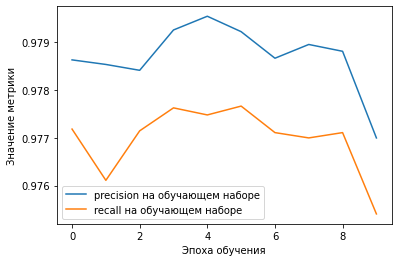

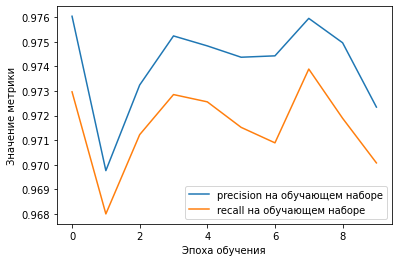

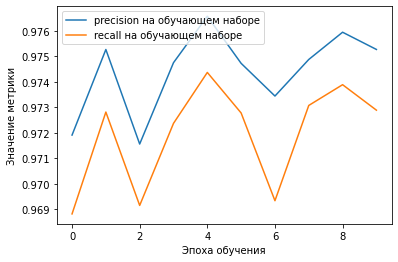

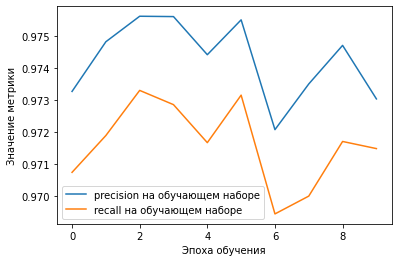

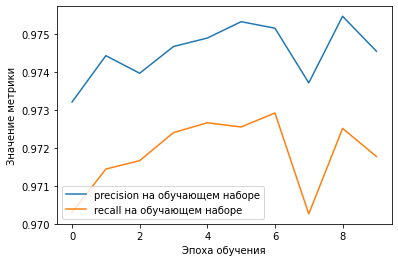

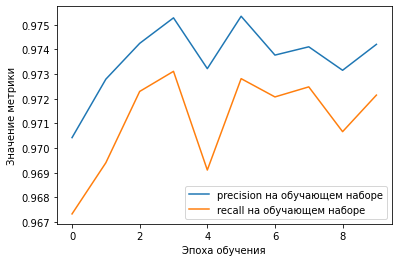

In [65]:
results = []
for kfold_x, kfold_x_test, kfold_y, kfold_y_test in splitted_Xy:
    model = None
    model = init_keras_model(visible_summary=False)
    results.append(
        train_and_evaluate_model(model, kfold_x, kfold_x_test, 
                                 kfold_y, kfold_y_test)
    )

### Оценка результатов кросс-валидации.

Результаты кросс-валидации

In [66]:
results

[[0.6122294068336487, 0.8169121742248535, 0.8056603670120239],
 [0.24200640618801117, 0.9687972664833069, 0.9666037559509277],
 [0.2381877601146698, 0.9632366895675659, 0.9590566158294678],
 [0.21808713674545288, 0.9743154048919678, 0.9733962416648865],
 [0.2098303884267807, 0.9765595197677612, 0.9747169613838196],
 [0.2245369553565979, 0.9665469527244568, 0.9649056792259216]]

Средние значения метрики на валидационных фолдах.


In [67]:
np.mean(results, axis=0)

array([0.29081301, 0.94439467, 0.94072327])

Видим, что на первом наборе данных было переобучение модели или же в первый тренировочный набор данных попали не все виды целевых переменных. На остальных наборах данных видим достаточно высокие и стабильные значения метрик. Делаем вывод, что подобрана оптимальная архитектура нейронной сети. Вывод: обучим модель на всех тренировочных данных.

## Тренировка модели.

In [68]:
nn_model = init_keras_model()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 batch_normalization_6 (Batc  (None, 100, 16)          64        
 hNormalization)                                                 
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100, 300)          95100     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 100, 100)          40100     
                                                                 
 dense_12 (Dense)            (None, 100, 100)          10100     
                                                                 
 dense_13 (Dense)            (None, 100, 9)            909       
                                                             

Last Precision: 0.9741218686103821
Last Recall: 0.9719504714012146
11/11 [==============================] - 1s 58ms/step - loss: 0.1612 - precision_20: 0.9766 - recall_20: 0.9750
Метрики:
Presicion: 0.97658771276474
Recall: 0.9750154614448547


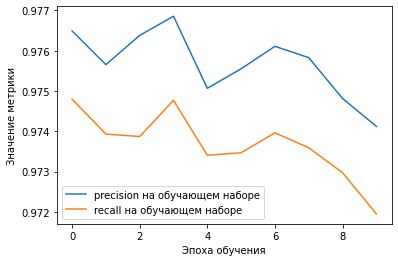

In [69]:
nn_result = train_and_evaluate_model(
    nn_model,
    X_train_nn,
    X_train_nn,
    y_train_nn,
    y_train_nn
)

nn_loss, nn_precision, nn_recall = nn_result

print(f"Метрики:\nPresicion: {nn_precision}\nRecall: {nn_recall}")

Предскажем тренировочные данные

In [70]:
y_pred_train_nn = nn_model.predict(X_train_nn)
y_pred_train_nn.shape

11/11 [==============================] - 1s 58ms/step


(323, 100, 9)

### Визуализация работы НС.

Функция для визуальной оценки работы нейронной сети.

График 1 - это данные зафиксированные оптомиографическими датчиками.

График 2 подача команды на совершение жеста для пилота.

График 3 - это предсказания модели.

График 4 - это фактическое движение, на тестовых данных именно оно будет использоваться для скоринга.

In [71]:
def train_example_show(X_train, y_train_nn, y_pred_train_nn, i):
    """Визуализация работы НС на конкретном примере.

    График 1 - это данные зафиксированные оптомиографическими датчиками.
    График 2 - подача команды на совершение жеста для пилота.
    График 3 - это предсказания модели. 
    График 4 - это фактическое движение, на тестовых данных именно
        оно будет использоваться для скоринга.

    Аргументы:
        X_train: тренировочный набор признаков.
        y_train_nn: тренировочная целевая переменная.
        y_pred_train_nn: предсказанная целевая переменная.
        i: номер конкретного примера.
    
    Возвращает:
        Ничего.

    """
    fig, axx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

    axx[0].plot(X_train[i].T)
    axx[0].set_title('OMG')

    axx[1].imshow(y_train_nn[i].T, origin="lower")
    axx[1].set_aspect('auto')
    axx[1].set_title('Marked up Class/Command')
    axx[1].set_yticks(
        np.arange(9),
        ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
    )

    axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
    axx[2].set_aspect('auto')
    axx[2].set_title('Model output')
    axx[2].set_yticks(
        np.arange(9),
        ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
    )

    axx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
    axx[3].set_aspect('auto')
    axx[3].set_title('Actual gesture')
    axx[3].set_yticks(
        np.arange(9),
        ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
    )
    axx[3].set_xlabel('Timestep')

    plt.suptitle(f'Train {i}')

    plt.tight_layout()

    plt.gcf()

Рассмотрим один пример.

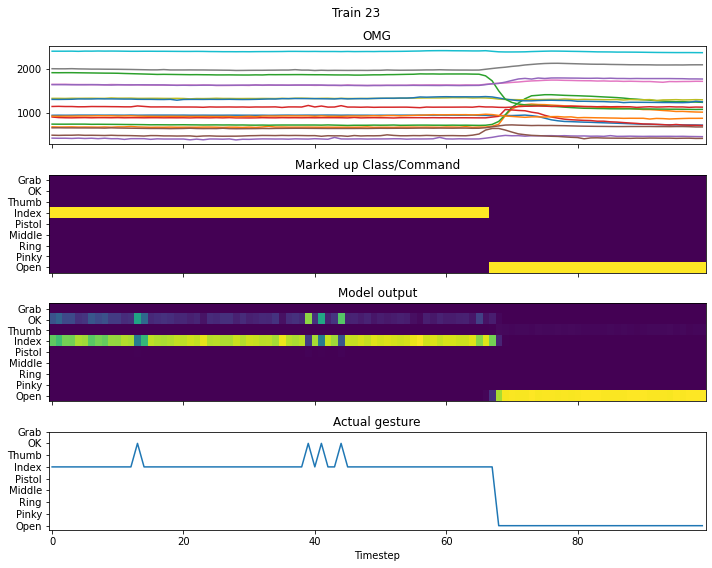

In [72]:
train_example_show(X_train, y_train_nn, y_pred_train_nn, 23)

В момент выполнения пользователем команды на сигналах датчиков наблюдаются переходные процессы, которые дают 
неоднозначное определение классов в предсказаниях нейронной сети. Для сглаживания этой неоднозначности предназначен блок постобработки.
В нем мы используем сглаживание модой с окном 7. Данное значение было определено экспериментальным путём.

### Постобработка результатов.

In [73]:
y_pred_train_nn_class = y_pred_train_nn.argmax(axis=-1)
y_pred_train_nn_class[22]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

Для борьбы с дребезгом будем использовать моду по 7 значениям.

In [74]:
from statistics import mode

def smooth_row(row, mode_value=7):
    """Сглаживание дребезга.

    Сглаживание дребезга в строках с использованием моды.

    Аргументы:
        row: строка с дребезгом.
        mode_value: количество значений, по которым происходит сглаживание,
            по умолчанию 7.
    
    Возвращает:
        smoothing_row: сглаженная строка.

    """
    smoothing_row = []
    for k in range(len(row)):
        smoothing_row.append(mode(row[k:(k + mode_value)]))
    len(smoothing_row)
    return smoothing_row

In [75]:
y_pred_train_nn_smooth = []
for row in y_pred_train_nn_class:
    y_pred_train_nn_smooth.append(smooth_row(row))
y_pred_train_nn_smooth = np.array(y_pred_train_nn_smooth)
y_pred_train_nn_smooth.shape

(323, 100)

Визуально оценим результат сглаживания.

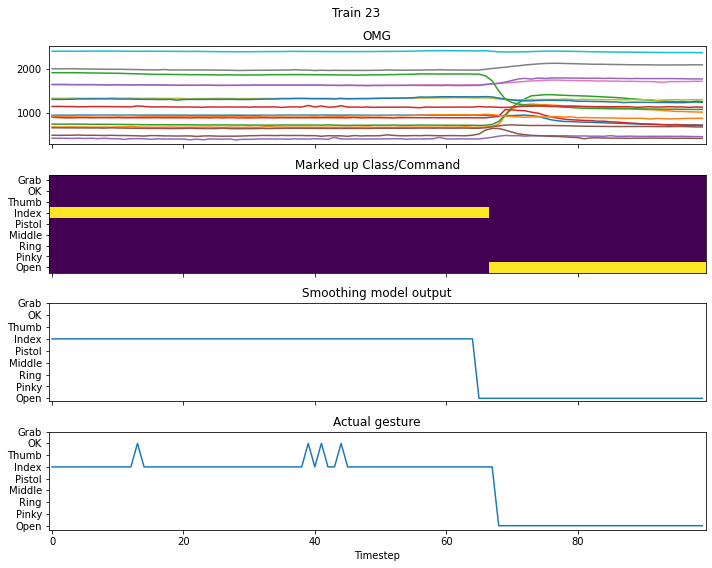

In [76]:
i = 23
figx, axxx = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axxx[0].plot(X_train[i].T)
axxx[0].set_title('OMG')

axxx[1].imshow(y_train_nn[i].T, origin="lower")
axxx[1].set_aspect('auto')
axxx[1].set_title('Marked up Class/Command')
axxx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

axxx[2].plot(y_pred_train_nn_smooth[i].T) # , vmin=-0.5, vmax=0.5
axxx[2].set_aspect('auto')
axxx[2].set_title('Smoothing model output')
axxx[2].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
axxx[3].plot(y_pred_train_nn[i].argmax(axis=-1))
axxx[3].set_aspect('auto')
axxx[3].set_title('Actual gesture')
axxx[3].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
axxx[3].set_xlabel('Timestep')

plt.suptitle(f'Train {i}')

plt.tight_layout()

# plt.gcf()

## Предсказываем значения на тестовой выборке.

In [77]:
y_pred_nn = nn_model.predict(X_test_nn).argmax(axis=-1)

print(y_pred_nn.shape)
y_pred_nn

2/2 [==============================] - 0s 35ms/step
(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

Сглаживаем.

In [78]:
y_pred_smooth = []
for row in y_pred_nn:
    y_pred_smooth.append(smooth_row(row))
y_pred_smooth = np.array(y_pred_smooth)
y_pred_smooth.shape

(54, 100)

Растягиваем в плоский массив для сабмита.

In [79]:
y_pred = np.concatenate([arr for arr in y_pred_smooth])

print(y_pred.shape)
y_pred

(5400,)


array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

### Создаем сабмит.

In [80]:
y_test['class'] = y_pred
y_test.to_csv('submit', index=False)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


LeaderBoard Score: 0.98703

# Сохраняем модель с лучшим скором

In [81]:
nn_model.save("model_1.h5")